# SCS_3253_047 Machine Learning

### Final Project: April 5th, 2022

### Team members:

* Lucas Merrick
* Amitha Pillai
* Michael Tan
* Herbert Gnanaraja Richard Sundarrajan

### Project Overview:

The scientific objective of the Kepler Mission is to explore the structure and diversity of planetary systems, using a special-purpose spacecraft to measure light variations from thousands of distant stars, looking for planetary transits.


Kepler Objects of Interest (KOIs) are well vetted, periodic, transit-like events in the Kepler data. The Kepler Project identifies these objects from the Threshold-Crossing Events (TCE) list for further vetting. Some objects will be flagged as false positives.

### Objective: 
Predict classification of KOI from Kepler data (exoplanet candidate or false positive)

### Data Exploration:

* Dataset with 82 features, 9564 instances
    * Identification Columns, Exoplanet Archive Information, Project Disposition Columns
    * Transit Properties, Threshold-Crossing Event (TCE) Information, Stellar Parameters, Kepler Input Catalog (KIC) Parameters, Pixel-Based KOI Vetting Statistics


* Plot distribution of features to evaluate data for extreme values, trends
    * Mix of distributions: majority left/right skewed, some normally distributed


* Plot correlation heatmap to identify potential correlations and understand relationships between pairs of features
    * High correlation found in subset of features
    
### Data source:

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
pathToFile = r"dataset/"
fileName = 'cumulative_values.csv'

In [3]:
rows = 86 # skip rows with column descriptions - only use this for file directly downloaded from archive

data = pd.read_csv(pathToFile+fileName, skiprows=rows, sep=",", index_col=0) # create dataframe
pd.set_option('display.max_columns', None) # show all columns

# 1. Data preparation & Exploratory data analysis

In [4]:
data.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_time0bk,koi_time0,koi_eccen,koi_longp,koi_impact,koi_duration,koi_ingress,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_model_dof,koi_model_chisq,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sage,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
rowid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,9.488036,170.538750,2455003.539,0.0,NaN,0.146,2.95750,NaN,615.8,0.022344,3.20796,LS+MCMC,2.26,0.0853,89.66,793.0,93.59,24.810,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,5.135849,28.470820,35.8,2,142.0,1.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.6864,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-001-2016...,5455.0,4.467,0.14,0.927,0.919,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,48.14191,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,54.418383,162.513840,2454995.514,0.0,NaN,0.586,4.50700,NaN,874.8,0.027954,3.02368,LS+MCMC,2.83,0.2734,89.57,443.0,9.11,77.900,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,7.027669,20.109507,25.8,2,25.0,2.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.0023,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-002-2016...,5455.0,4.467,0.14,0.927,0.919,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,48.14199,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,0,0,q1_q17_dr25_sup_koi,DEEP_V_SHAPED,19.899140,175.850252,2455008.850,0.0,NaN,0.969,1.78220,NaN,10829.0,0.154046,7.29555,LS+MCMC,14.60,0.1419,88.96,638.0,39.30,53.500,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2711,0.3858,q1_q17_dr25_koi,37.159767,187.449100,76.3,1,56.0,1.0,q1_q17_dr25_tce,11111101110111011000000000000000,0.6624,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010811/010811496/dv/kplr010811496-20160209...,010/010811/010811496/dv/kplr010811496-001-2016...,5853.0,4.544,-0.18,0.868,0.961,NaN,q1_q17_dr25_stellar,297.00482,48.134129,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,0.278,19.800321,48.13412,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,0,0,q1_q17_dr25_sup_koi,MOD_ODDEVEN_DV---MOD_ODDEVEN_ALT---DEEP_V_SHAPED,1.736952,170.307565,2455003.308,0.0,NaN,1.276,2.40641,NaN,8079.2,0.387394,0.22080,LS+MCMC,33.46,0.0267,67.09,1395.0,891.96,3.278,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2865,0.3556,q1_q17_dr25_koi,39.066550,541.895100,505.6,1,621.0,1.0,q1_q17_dr25_tce,11111110111011101000000000000000,0.0000,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010848/010848459/dv/kplr010848459-20160209...,010/010848/010848459/dv/kplr010848459-001-2016...,5805.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9564 entries, 1 to 9564
Data columns (total 82 columns):
kepid                9564 non-null int64
kepoi_name           9564 non-null object
kepler_name          2670 non-null object
koi_disposition      9564 non-null object
koi_vet_stat         9564 non-null object
koi_vet_date         9564 non-null object
koi_pdisposition     9564 non-null object
koi_score            8054 non-null float64
koi_fpflag_nt        9564 non-null int64
koi_fpflag_ss        9564 non-null int64
koi_fpflag_co        9564 non-null int64
koi_fpflag_ec        9564 non-null int64
koi_disp_prov        9564 non-null object
koi_comment          8355 non-null object
koi_period           9564 non-null float64
koi_time0bk          9564 non-null float64
koi_time0            9564 non-null float64
koi_eccen            9201 non-null float64
koi_longp            0 non-null float64
koi_impact           9201 non-null float64
koi_duration         9564 non-null float64
koi_ingress

In [6]:
# Removing few columns which are not data
skip_attr = [ 
    'koi_fittype', 
    'koi_limbdark_mod', 
    'koi_parm_prov', 
    'koi_tce_delivname',
    'koi_quarters',
    'koi_trans_mod',
    'koi_datalink_dvr',
    'koi_datalink_dvs',
    'koi_sparprov'
]


df = data.iloc[:, 14:] # remove first 13 columns of identification and target data (includes koi_fpflag_xx)
df.drop(skip_attr, axis=1, inplace=True) # drop columns with documentation data
df.shape # output is (9564, 59)

(9564, 59)

In [7]:
df_clean = df.dropna(axis=1, how='all') # drop all NaN/null columns
df_clean = df_clean.loc[:, (df_clean.sum(axis=0) != 0)] # drop all columns with zero data
df_clean.shape # output is (9564, 51)

(9564, 51)

In [8]:
target_attr = 'koi_pdisposition'
target_vals = {'CANDIDATE': 1, 'FALSE POSITIVE': 0}
df_clean[target_attr] = data[target_attr].map(target_vals) # get prediction labels

In [9]:
df_clean.describe()

,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff2,koi_ldm_coeff1,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_bin_oedp_sig,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,koi_pdisposition
count,9564.000000,9564.000000,9.564000e+03,9201.000000,9564.000000,9.201000e+03,9201.000000,9243.000000,9201.000000,9201.000000,9200.000000,9201.000000,9.243000e+03,9201.000000,9201.000000,9201.000000,8422.000000,8422.000000,9201.000000,9564.000000,8422.000000,9218.000000,8054.000000,9201.000000,9201.000000,9178.000000,9201.000000,9201.000000,9564.000000,9564.000000,9563.000000,9523.000000,9555.000000,9410.000000,8951.000000,9539.000000,9539.000000,9539.00000,8488.000000,9058.000000,9058.000000,9109.000000,9109.000000,8734.000000,8747.000000,8965.000000,8965.000000,8965.000000,8994.000000,8994.000000,8994.000000,9564.000000
mean,75.671358,166.183251,2.454999e+06,0.735105,5.621606,2.379134e+04,0.283646,9.164414,102.891778,0.223989,82.469147,1085.385828,7.745737e+03,76.736333,0.254439,0.407617,176.846052,1025.664672,259.895001,1.406315,385.006768,1.243654,0.409500,5706.823280,4.310157,-0.124431,1.728712,1.023706,292.060163,43.810433,14.264606,14.830501,14.221565,14.075138,13.991724,12.993311,12.620604,12.54341,0.150994,19.471356,43.829239,-0.316136,-0.165817,-0.000097,-0.000714,-0.012281,-0.045420,1.866561,-0.024244,-0.076749,1.812566,0.493204
std,1334.744046,67.918960,6.791896e+01,3.348832,6.471554,8.224268e+04,3.306558,53.807967,3077.639126,0.566359,15.223627,856.351161,1.592047e+05,845.274598,0.064806,0.106076,770.902357,4154.121620,795.806615,0.873289,545.756200,0.664573,0.500793,796.857947,0.432606,0.282111,6.127185,0.349447,4.766657,3.601243,1.385448,1.501885,1.383713,1.292573,1.230351,1.291912,1.267215,1.26818,0.252648,0.319158,3.599553,20.254777,20.534655,0.058224,0.092986,2.406550,2.573558,2.988742,2.382286,2.553758,2.986376,0.499980
min,0.241843,120.515914,2.454954e+06,0.000000,0.052000,0.000000e+00,0.001289,0.000040,0.080000,0.005900,2.290000,25.000000,0.000000e+00,0.373000,-0.120600,0.125400,2.417437,7.105086,0.000000,1.000000,0.000000,1.000000,-1.000000,2661.000000,0.047000,-2.500000,0.109000,0.000000,279.852720,36.577381,6.966000,7.225000,7.101000,7.627000,6.702000,4.097000,3.014000,2.31100,0.000000,18.657036,36.576888,-742.430000,-417.900000,-4.000000,-6.000000,-25.100000,-75.900000,0.000000,-27.800000,-76.600000,0.000000,0.000000
25%,2.733684,132.761718,2.454966e+06,0.197000,2.437750,1.599000e+02,0.012341,0.229250,1.400000,0.037700,83.920000,539.000000,2.015000e+01,5.358000,0.228600,0.326800,3.997856,10.733030,12.000000,1.000000,41.000000,1.000000,0.134650,5310.000000,4.218000,-0.260000,0.829000,0.845000,288.660770,40.777173,13.440000,13.896500,13.393000,13.294000,13.276000,12.253000,11.914500,11.84300,0.000000,19.243889,40.798688,-0.600000,-0.680000,-0.000210,-0.000220,-0.320000,-0.387000,0.170000,-0.310000,-0.390000,0.210000,0.000000
50%,9.752831,137.224595,2.454970e+06,0.537000,3.792600,4.211000e+02,0.021076,0.956720,2.390000,0.085100,88.500000,878.000000,1.416000e+02,15.460000,0.271100,0.392000,5.589751,19.254412,23.000000,1.000000,143.000000,1.000000,0.486600,5767.000000,4.438000,-0.100000,1.000000,0.974000,292.261125,43.677504,14.520000,15.064000,14.471000,14.317500,14.254000,13.236000,12.834000,12.74400,0.006000,19.484983,43.694115,-0.000500,-0.034000,0.000000,0.000000,0.000000,0.000000,0.610000,-0.004000,-0.017000,0.583000,0.000000
75%,40.715178,170.694603,2.455004e+06,0.889000,6.276500,1.473400e+03,0.095348,2.897175,14.930000,0.214400,89.770000,1379.000000,8.702900e+02,45.370000,0.299800,0.464100,16.947631,71.9

The data have huge outliers, if any tecnique such as IQR is applied, then 95% of the data identified as outlier, hence we will remove highly visible outliers.

In [10]:
df_outliersDropped = df_clean.copy()

df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_period']>10000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_time0bk']>1400].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_impact']>70].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_duration']>100].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_depth']>10000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_ror']>80].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_srho']>900].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_prad']>1000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_teq']>14000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_dor']>2000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_max_sngle_ev']>20000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_max_mult_ev']>50000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_model_snr']>1000].index,inplace=True)
df_outliersDropped.drop(df_outliersDropped[df_outliersDropped['koi_srad']>100].index,inplace=True)

### Check for any missing values

In [11]:
df_outliersDropped.isnull().sum().sum()

19117

There are a lot of missing values in the dataset, we will impute the data using simpleImputer in the pipeline. Since the data had lot of outliers, we will use mean to include the weightage.

In [13]:
fig = plt.figure(figsize=(80, 400))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for i, col in enumerate(df_outliersDropped.columns):
    ax=plt.subplot(18,3,1 + i)
    sns.scatterplot(x="koi_pdisposition", y=col, data=df_outliersDropped)
    ax.tick_params(axis='both', which='major', labelsize=50)
    plt.title(col, fontdict={'fontsize': 50})

plt.show()

## Observations:

* As seen in the pair plot, every feature is little contributed to the target variable
* The above scatter plot shows each feature distributed for the target varible. There is no significant correlation
* Though we have more data, but compared to the number of objects in the outerscape, we can assume that the kepler telescope captured only few of them. This is observed in the data are not normally distributed
* Considering all the data collected are important and though the number of outliers are more, but they are assumed not an error, hence removed only a visible outliers

# 2. Model training and validation

### Split data for training and test

In [14]:
train_set, test_set = train_test_split(df_outliersDropped, test_size=0.2, random_state=42)

### Define function to train & GridSearch for any estimator

In [16]:
def modelTrain(X, y, estimator_name, estimator, param_grid, cv=3, scoring='accuracy'):
    
    #Define pipeline

    pipeline = Pipeline(steps=[
            ("imputer",SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            (estimator_name, estimator)
        ])
    
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv,
                           scoring=scoring,
                           return_train_score=True)

    return grid_search.fit(X, y)


In [17]:
X_train = train_set.drop('koi_pdisposition', axis=1).astype(np.float64)
y_train = train_set['koi_pdisposition']

### Train on Linear model

In [18]:
sgd_clf = linear_model.SGDClassifier()
param_grid = [
    {'sgd_clf__max_iter': [10, 100,1000]}
  ]

sgd_clf_model = modelTrain(X_train, y_train, 'sgd_clf', sgd_clf, param_grid, 5, 'accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packag

In [19]:
sgd_clf_model.best_params_

{'sgd_clf__max_iter': 1000}

In [31]:
X_test = test_set.drop('koi_pdisposition', axis=1).astype(np.float64)
y_test = test_set['koi_pdisposition']

y_test_pred = sgd_clf_model.predict(X_test)

In [32]:
sgd_clf_acc = accuracy_score(y_test, y_test_pred)
sgd_clf_acc, sgd_clf_model.best_score_

(0.8134651019147622, 0.8372447447447448)

The prediction on test data is better as the test score has increased from the training score

### Confusion Matrix for Linear model

(2.0, 0.0)

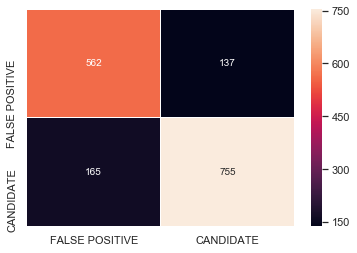

In [25]:
conf_mx = confusion_matrix(y_test, y_test_pred)
# conf_mx
conf_mx_df = pd.DataFrame(conf_mx, columns=['FALSE POSITIVE','CANDIDATE'], index=['FALSE POSITIVE','CANDIDATE'])
ax =sns.heatmap(conf_mx_df, annot=True, linewidths=.5,  fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The Linear model looked to be overfit, the test score was lesser than the training score. However, it predicted fewer False positive and false negative

### Train on SVC model

In [26]:
#SVC

svc = SVC()

param_grid = [{'svc__kernel' : ['linear', 'rbf', 'poly'],
                'svc__degree' :[0, 1, 2, 3, 4, 5, 6],
              'svc__C' : [1,5,10,1000]}]



svc_model = modelTrain(X_train, y_train, 'svc', svc, param_grid, 5, 'accuracy')

In [27]:
y_test_pred = svc_model.predict(X_test)

In [30]:
svc_model.best_params_

{'svc__C': 5, 'svc__degree': 0, 'svc__kernel': 'rbf'}

In [28]:
svc_acc = accuracy_score(y_test, y_test_pred)
svc_acc, svc_model.best_score_

(0.8844966028412601, 0.8704454454454454)

The SVC performed good on prediction, the score is slightly more than the training score

### Train on Random Forest Model

In [ ]:
#RF

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

param_grid = [{'rfc__n_estimators' : [500, 1000, 1500],
               'rfc__max_leaf_nodes' :[15, 20, 25],
               'rfc__max_depth' : [i for i in range(8, 11)]}]

rnd_clf = modelTrain(X_train, y_train, 'rfc', rfc, param_grid, 5, 'accuracy')

In [ ]:
rnd_clf.best_params_

In [ ]:
y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
rfc_acc = accuracy_score(y_test, y_pred_rf)
rfc_acc, rnd_clf.best_score_

### Confusion Matrix for SVC model

(2.0, 0.0)

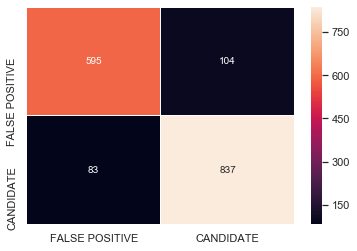

In [29]:
conf_mx = confusion_matrix(y_test, y_test_pred)
# conf_mx
conf_mx_df = pd.DataFrame(conf_mx, columns=['FALSE POSITIVE','CANDIDATE'], index=['FALSE POSITIVE','CANDIDATE'])
ax =sns.heatmap(conf_mx_df, annot=True, linewidths=.5,  fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## 3. Conclusion

The SVC performed better than the linear model, It prediected less false negative and false positive compared to Linear. Since the data don't look represent the complete population, they are not normally distributed. We will need to include most of the outliered data to train the model. This is because not to loose all important data, they are not considered as error in collection.